# Intro

In [19]:
import os
import h5py
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.optim as optim

from sklearn.metrics import roc_auc_score

from torchvision import models
from tqdm.auto import tqdm

In [2]:
# If using GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
METADATA_COL2DESC = {
    "isic_id": "Unique identifier for each image case.",
    "target": "Binary class label (0 = benign, 1 = malignant).",
    "patient_id": "Unique identifier for each patient.",
    "age_approx": "Approximate age of the patient at time of imaging.",
    "sex": "Sex of the patient (male or female).",
    "anatom_site_general": "General location of the lesion on the patient's body.",
    "clin_size_long_diam_mm": "Maximum diameter of the lesion (mm).",
    "image_type": "Type of image captured, as defined in the ISIC Archive.",
    "tbp_tile_type": "Lighting modality of the 3D Total Body Photography (TBP) source image.",
    "tbp_lv_A": "Color channel A (green-red axis in LAB space) inside the lesion.",
    "tbp_lv_Aext": "Color channel A outside the lesion.",
    "tbp_lv_B": "Color channel B (blue-yellow axis in LAB space) inside the lesion.",
    "tbp_lv_Bext": "Color channel B outside the lesion.",
    "tbp_lv_C": "Chroma value inside the lesion.",
    "tbp_lv_Cext": "Chroma value outside the lesion.",
    "tbp_lv_H": "Hue value inside the lesion (LAB color space).",
    "tbp_lv_Hext": "Hue value outside the lesion.",
    "tbp_lv_L": "Luminance inside the lesion (LAB color space).",
    "tbp_lv_Lext": "Luminance outside the lesion.",
    "tbp_lv_areaMM2": "Area of the lesion in mm².",
    "tbp_lv_area_perim_ratio": "Ratio of the lesion's perimeter to its area (border jaggedness).",
    "tbp_lv_color_std_mean": "Mean color irregularity within the lesion.",
    "tbp_lv_deltaA": "Average contrast in color channel A between inside and outside.",
    "tbp_lv_deltaB": "Average contrast in color channel B between inside and outside.",
    "tbp_lv_deltaL": "Average contrast in luminance between inside and outside.",
    "tbp_lv_deltaLB": "Combined contrast between the lesion and surrounding skin.",
    "tbp_lv_deltaLBnorm": "Normalized contrast (LAB color space).",
    "tbp_lv_eccentricity": "Eccentricity of the lesion (how elongated it is).",
    "tbp_lv_location": "Detailed anatomical location (e.g., Upper Arm).",
    "tbp_lv_location_simple": "Simplified anatomical location (e.g., Arm).",
    "tbp_lv_minorAxisMM": "Smallest diameter of the lesion in mm.",
    "tbp_lv_nevi_confidence": "Confidence score (0-100) for the lesion being a nevus.",
    "tbp_lv_norm_border": "Normalized border irregularity (0-10 scale).",
    "tbp_lv_norm_color": "Normalized color variation (0-10 scale).",
    "tbp_lv_perimeterMM": "Perimeter of the lesion in mm.",
    "tbp_lv_radial_color_std_max": "Color asymmetry within the lesion, measured radially.",
    "tbp_lv_stdL": "Std. deviation of luminance inside the lesion.",
    "tbp_lv_stdLExt": "Std. deviation of luminance outside the lesion.",
    "tbp_lv_symm_2axis": "Asymmetry about a second axis of symmetry.",
    "tbp_lv_symm_2axis_angle": "Angle of that second axis of symmetry.",
    "tbp_lv_x": "X-coordinate in the 3D TBP model.",
    "tbp_lv_y": "Y-coordinate in the 3D TBP model.",
    "tbp_lv_z": "Z-coordinate in the 3D TBP model.",
    "attribution": "Image source or institution.",
    "copyright_license": "License information.",
    "lesion_id": "Unique ID for lesions of interest.",
    "iddx_full": "Full diagnosis classification.",
    "iddx_1": "First-level (broad) diagnosis.",
    "iddx_2": "Second-level diagnosis.",
    "iddx_3": "Third-level diagnosis.",
    "iddx_4": "Fourth-level diagnosis.",
    "iddx_5": "Fifth-level diagnosis.",
    "mel_mitotic_index": "Mitotic index of invasive malignant melanomas.",
    "mel_thick_mm": "Thickness of melanoma invasion in mm.",
    "tbp_lv_dnn_lesion_confidence": "Lesion confidence score (0-100) from a DNN classifier."
}

METADATA_COL2NAME = {
    "isic_id": "Unique Case Identifier",
    "target": "Binary Lesion Classification",
    "patient_id": "Unique Patient Identifier",
    "age_approx": "Approximate Age",
    "sex": "Sex",
    "anatom_site_general": "General Anatomical Location",
    "clin_size_long_diam_mm": "Clinical Size (Longest Diameter in mm)",
    "image_type": "Image Type",
    "tbp_tile_type": "TBP Tile Type",
    "tbp_lv_A": "Color Channel A (Inside)",
    "tbp_lv_Aext": "Color Channel A (Outside)",
    "tbp_lv_B": "Color Channel B (Inside)",
    "tbp_lv_Bext": "Color Channel B (Outside)",
    "tbp_lv_C": "Chroma (Inside)",
    "tbp_lv_Cext": "Chroma (Outside)",
    "tbp_lv_H": "Hue (Inside)",
    "tbp_lv_Hext": "Hue (Outside)",
    "tbp_lv_L": "Luminance (Inside)",
    "tbp_lv_Lext": "Luminance (Outside)",
    "tbp_lv_areaMM2": "Lesion Area (mm²)",
    "tbp_lv_area_perim_ratio": "Area-to-Perimeter Ratio",
    "tbp_lv_color_std_mean": "Mean Color Irregularity",
    "tbp_lv_deltaA": "Delta A",
    "tbp_lv_deltaB": "Delta B",
    "tbp_lv_deltaL": "Delta L",
    "tbp_lv_deltaLB": "Delta LB",
    "tbp_lv_deltaLBnorm": "Normalized Delta LB",
    "tbp_lv_eccentricity": "Eccentricity",
    "tbp_lv_location": "Detailed Location",
    "tbp_lv_location_simple": "Simplified Location",
    "tbp_lv_minorAxisMM": "Smallest Diameter (mm)",
    "tbp_lv_nevi_confidence": "Nevus Confidence Score",
    "tbp_lv_norm_border": "Normalized Border Irregularity",
    "tbp_lv_norm_color": "Normalized Color Variation",
    "tbp_lv_perimeterMM": "Lesion Perimeter (mm)",
    "tbp_lv_radial_color_std_max": "Radial Color Deviation",
    "tbp_lv_stdL": "Std. Dev. Luminance (Inside)",
    "tbp_lv_stdLExt": "Std. Dev. Luminance (Outside)",
    "tbp_lv_symm_2axis": "Symmetry (Second Axis)",
    "tbp_lv_symm_2axis_angle": "Symmetry Angle (Second Axis)",
    "tbp_lv_x": "X-Coordinate",
    "tbp_lv_y": "Y-Coordinate",
    "tbp_lv_z": "Z-Coordinate",
    "attribution": "Image Source",
    "copyright_license": "Copyright",
    "lesion_id": "Unique Lesion ID",
    "iddx_full": "Full Diagnosis",
    "iddx_1": "Diagnosis Level 1",
    "iddx_2": "Diagnosis Level 2",
    "iddx_3": "Diagnosis Level 3",
    "iddx_4": "Diagnosis Level 4",
    "iddx_5": "Diagnosis Level 5",
    "mel_mitotic_index": "Mitotic Index (Melanoma)",
    "mel_thick_mm": "Melanoma Thickness (mm)",
    "tbp_lv_dnn_lesion_confidence": "Lesion DNN Confidence"
}

# Custom Dataset for HDF5

In [4]:
class ISIC_HDF5_Dataset(Dataset):
    """
    A PyTorch Dataset that loads images from an HDF5 file given a DataFrame of IDs.
    Applies image transforms suitable for ResNet50.
    """
    def __init__(self, df: pd.DataFrame, hdf5_path: str, transform=None, is_labelled: bool = True):
        """
        Args:
            df (pd.DataFrame): DataFrame containing 'isic_id' and optionally 'target'.
            hdf5_path (str): Path to the HDF5 file containing images.
            transform (callable): Optional transforms to be applied on a sample.
            is_labelled (bool): Whether the dataset includes labels (for train/val).
        """
        self.df = df.reset_index(drop=True)
        self.hdf5_path = hdf5_path
        self.transform = transform
        self.is_labelled = is_labelled

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        isic_id = row["isic_id"]
        
        # Load image from HDF5
        image_rgb = self._load_image_from_hdf5(isic_id)
        
        # Apply transforms (PIL-style transforms require converting np array to PIL, or we can do tensor transforms)
        if self.transform is not None:
            # Convert NumPy array (H x W x C) to a PIL Image
            import torchvision.transforms.functional as F_v
            image_pil = F_v.to_pil_image(image_rgb)
            image = self.transform(image_pil)
        else:
            # By default, convert it to a tensor (C x H x W)
            image = torch.from_numpy(image_rgb).permute(2, 0, 1).float()

        if self.is_labelled:
            label = row["target"]
            label = torch.tensor(label).float()
            return image, label, isic_id
        else:
            return image, isic_id

    def _load_image_from_hdf5(self, isic_id: str):
        """
        Loads and decodes an image from HDF5 by isic_id.
        Returns a NumPy array in RGB format (H x W x 3).
        """
        with h5py.File(self.hdf5_path, 'r') as hf:
            encoded_bytes = hf[isic_id][()]  # uint8 array

        # If it's bytes (not np.ndarray), convert it
        if isinstance(encoded_bytes, bytes):
            encoded_bytes = np.frombuffer(encoded_bytes, dtype=np.uint8)
        elif isinstance(encoded_bytes, np.ndarray) and encoded_bytes.dtype != np.uint8:
            encoded_bytes = encoded_bytes.astype(np.uint8)

        # Decode the image bytes with OpenCV (returns BGR)
        image_bgr = cv2.imdecode(encoded_bytes, cv2.IMREAD_COLOR)
        # Convert to RGB
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        return image_rgb

# Data Setup

In [5]:
TRAIN_METADATA_CSV = "/Users/jorgecamposmarti/Documents/Máster/4o Semicuatrimestre/3. ML (Machine Learning)/Project 2/data/new-train-metadata.csv"
TEST_METADATA_CSV  = "/Users/jorgecamposmarti/Documents/Máster/4o Semicuatrimestre/3. ML (Machine Learning)/Project 2/data/students-test-metadata.csv"
TRAIN_HDF5         = "/Users/jorgecamposmarti/Documents/Máster/4o Semicuatrimestre/3. ML (Machine Learning)/Project 2/data/train-image.hdf5"
TEST_HDF5          = "/Users/jorgecamposmarti/Documents/Máster/4o Semicuatrimestre/3. ML (Machine Learning)/Project 2/data/test-image.hdf5"

train_df = pd.read_csv(TRAIN_METADATA_CSV)
test_df  = pd.read_csv(TEST_METADATA_CSV)

print(f"train_df shape: {train_df.shape}")
print(f"test_df shape:  {test_df.shape}")

train_df shape: (400959, 55)
test_df shape:  (100, 44)


/var/folders/8g/6pyhwxxx6y147q2dm10zjk1w0000gn/T/ipykernel_80333/2683077871.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(TRAIN_METADATA_CSV)


In [6]:
print(train_df.columns[51])
print(train_df.columns[52])

iddx_5
mel_mitotic_index


Different columns between train and test:

In [7]:
train_columns = set(train_df.columns)
test_columns = set(test_df.columns)

only_in_train = train_columns - test_columns
only_in_test  = test_columns - train_columns

print("Columns only in train_df:", only_in_train)
print("Columns only in test_df:", only_in_test)

Columns only in train_df: {'tbp_lv_dnn_lesion_confidence', 'iddx_2', 'iddx_full', 'mel_thick_mm', 'iddx_3', 'iddx_1', 'iddx_4', 'target', 'mel_mitotic_index', 'lesion_id', 'iddx_5'}
Columns only in test_df: set()


- "target": "Binary class label (0 = benign, 1 = malignant).",
- "lesion_id": "Unique ID for lesions of interest.",
- "iddx_full": "Full diagnosis classification.",
- "iddx_1": "First-level (broad) diagnosis.",
- "iddx_2": "Second-level diagnosis.",
- "iddx_3": "Third-level diagnosis.",
- "iddx_4": "Fourth-level diagnosis.",
- "iddx_5": "Fifth-level diagnosis.",
- "mel_mitotic_index": "Mitotic index of invasive malignant melanomas.",
- "mel_thick_mm": "Thickness of melanoma invasion in mm.",
- "tbp_lv_dnn_lesion_confidence": "Lesion confidence score (0-100) from a DNN classifier."

Class imbalance: undersample class 0 so it has the same number of samples as class 1:

In [8]:
class_counts = train_df['target'].value_counts()
print(class_counts)

target
0    400616
1       343
Name: count, dtype: int64


In [9]:
# Separate the two classes
class_0_df = train_df[train_df['target'] == 0]
class_1_df = train_df[train_df['target'] == 1]

# Determine how many samples are in the minority class (class 1)
n_class_1 = len(class_1_df)

# Randomly undersample class 0
class_0_undersampled = class_0_df.sample(n=n_class_1, random_state=42)

# Concatenate both to get a balanced dataframe
train_df = pd.concat([class_0_undersampled, class_1_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Check result
print(train_df['target'].value_counts())

target
0    343
1    343
Name: count, dtype: int64


In [10]:
# Example: split train_df into 80% train / 20% valid
train_size = int(0.8 * len(train_df))
valid_size = len(train_df) - train_size
train_subset, valid_subset = random_split(
    train_df, 
    [train_size, valid_size],
    generator=torch.Generator().manual_seed(42)
)

train_df_sub = train_df.iloc[train_subset.indices].reset_index(drop=True)
valid_df_sub = train_df.iloc[valid_subset.indices].reset_index(drop=True)

print(f"Train samples: {len(train_df_sub)}, Valid samples: {len(valid_df_sub)}")

Train samples: 548, Valid samples: 138


In [11]:
"""# Basic transforms for ResNet
resnet_transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])"""

resnet_transforms = T.Compose([
    T.RandomHorizontalFlip(),       # Random each call
    T.RandomRotation(15),           # Random each call
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


# Create Datasets
train_dataset = ISIC_HDF5_Dataset(
    df=train_df_sub, 
    hdf5_path=TRAIN_HDF5,
    transform=resnet_transforms,
    is_labelled=True
)

valid_dataset = ISIC_HDF5_Dataset(
    df=valid_df_sub,
    hdf5_path=TRAIN_HDF5,
    transform=resnet_transforms,
    is_labelled=True
)

test_dataset = ISIC_HDF5_Dataset(
    df=test_df,
    hdf5_path=TEST_HDF5,
    transform=resnet_transforms,
    is_labelled=False
)

print("Created train/valid/test datasets.")

Created train/valid/test datasets.


In [12]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Train loader: {len(train_loader)} batches")
print(f"Valid loader: {len(valid_loader)} batches")
print(f"Test loader:  {len(test_loader)} batches")

Train loader: 18 batches
Valid loader: 5 batches
Test loader:  4 batches


# Models

## ResNet50

### 1. Unfrozen, last FC layer changed - 0.31

In [ ]:
"""model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Replace final layer for binary classification
model.fc = nn.Linear(in_features=2048, out_features=1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 15

# Initialize variables to track the best model
best_val_loss = float('inf')  # Start with a very large number
train_losses = []  # To store training losses
val_losses = []    # To store validation losses
best_model = None  # Variable to store the best model

for epoch in range(1, EPOCHS+1):

    # -- TRAINING --
    model.train()
    running_loss = 0.0
    
    for images, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images).view(-1)  # [batch_size]
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    
    # -- VALIDATING --

    model.eval()
    val_loss = 0.0
    all_logits = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images).view(-1)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            all_logits.append(logits.cpu())  # Save logits
            all_labels.append(labels.cpu())  # Save true labels

    
    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    # Concatenate all predictions and labels
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    # Convert logits to probabilities using sigmoid
    probs = torch.sigmoid(all_logits)

    # Compute AUC-ROC
    auc = roc_auc_score(all_labels.numpy(), probs.numpy())
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val AUC: {auc:.4f}")

    # -- Check if this is the best model so far --
    if avg_val_loss < best_val_loss:
        #print(f"Validation loss decreased ({best_val_loss:.4f} -> {avg_val_loss:.4f}). Saving model...")
        best_val_loss = avg_val_loss
        best_model = model.state_dict()  # Save the model's state dict in the variable

# If you want to load the best model from the variable:
model.load_state_dict(best_model)
model = model.to(device)
print(f"Best model val loss: {best_val_loss}")"""

In [27]:
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Replace final layer for binary classification
model.fc = nn.Linear(in_features=2048, out_features=1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10

# Initialize variables to track the best model
best_auc = 0
train_losses = []  # To store training losses
val_losses = []    # To store validation losses
best_model = None  # Variable to store the best model

for epoch in range(1, EPOCHS+1):

    # -- TRAINING --
    model.train()
    running_loss = 0.0
    
    for images, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images).view(-1)  # [batch_size]
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    
    # -- VALIDATING --

    model.eval()
    val_loss = 0.0
    all_logits = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images).view(-1)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            all_logits.append(logits.cpu())  # Save logits
            all_labels.append(labels.cpu())  # Save true labels

    
    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    # Concatenate all predictions and labels
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    # Convert logits to probabilities using sigmoid
    probs = torch.sigmoid(all_logits)

    # Compute AUC-ROC
    auc = roc_auc_score(all_labels.numpy(), probs.numpy())
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val AUC: {auc:.4f}")

    # -- Check if this is the best model so far --
    if auc > best_auc:
        print('best until now')
        best_auc = auc
        best_model = model.state_dict()  # Save the model's state dict in the variable

# If you want to load the best model from the variable:
model.load_state_dict(best_model)
model = model.to(device)
print(f"Best model val ROC AUC: {best_auc}")

Epoch 1:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.6504 | Val Loss: 0.6323 | Val AUC: 0.7394
best until now


Epoch 2:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.5184 | Val Loss: 0.4740 | Val AUC: 0.8576
best until now


Epoch 3:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.4041 | Val Loss: 0.4448 | Val AUC: 0.8827
best until now


Epoch 4:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.2986 | Val Loss: 0.4116 | Val AUC: 0.8867
best until now


Epoch 5:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.2259 | Val Loss: 0.4005 | Val AUC: 0.9010
best until now


Epoch 6:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.2499 | Val Loss: 0.3553 | Val AUC: 0.9144
best until now


Epoch 7:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.1260 | Val Loss: 0.5127 | Val AUC: 0.8831


Epoch 8:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.1864 | Val Loss: 0.4121 | Val AUC: 0.9023


Epoch 9:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.1465 | Val Loss: 0.4469 | Val AUC: 0.8850


Epoch 10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.1334 | Val Loss: 0.5385 | Val AUC: 0.8838
Best model val ROC AUC: 0.914413455397062


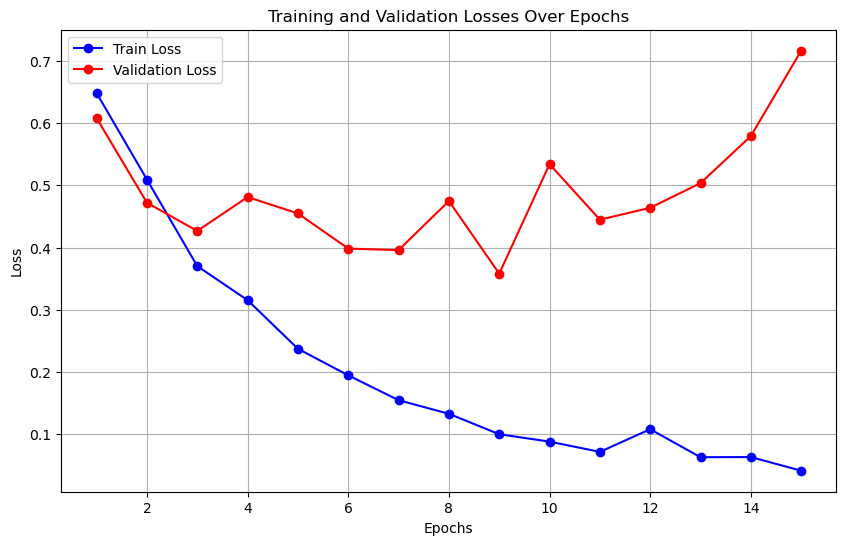

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
model.eval()
predictions = []

with torch.no_grad():
    for images, isic_ids in tqdm(test_loader, desc="Inference on Test"):
        images = images.to(device)
        logits = model(images).view(-1)  # shape [batch_size]
        probs = torch.sigmoid(logits)    # shape [batch_size], in [0,1]
        
        probs = probs.cpu().numpy()
        
        for isic_id, p in zip(isic_ids, probs):
            predictions.append({"isic_id": isic_id, "target": float(p)})

submission_df = pd.DataFrame(predictions)
submission_df = submission_df.sort_values(by="isic_id").reset_index(drop=True)

submission_file = "submission_I_RN50_2.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Saved submission with {len(submission_df)} rows to {submission_file}")
display(submission_df.head(10))

Inference on Test:   0%|          | 0/4 [00:00<?, ?it/s]

Saved submission with 100 rows to submission_I_RN50_2.csv


,isic_id,target
0,ISIC_0082829,0.999009
1,ISIC_0114227,0.015555
2,ISIC_0157465,0.068935
3,ISIC_0197356,0.085714
4,ISIC_0275647,0.006463
5,ISIC_0332355,0.597073
6,ISIC_0528190,0.983189
7,ISIC_0576478,0.005685
8,ISIC_0719839,0.797924
9,ISIC_0968965,0.167483


### 2. Frozen parameters, train only clasifier - 0.61

In [ ]:
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
model.fc = nn.Linear(in_features=2048, out_features=1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

EPOCHS = 20

# Initialize variables to track the best model
best_val_loss = float('inf')  # Start with a very large number
train_losses = []  # To store training losses
val_losses = []    # To store validation losses
best_model = None  # Variable to store the best model

for epoch in range(1, EPOCHS+1):

    # -- TRAINING --
    model.train()
    running_loss = 0.0
    
    for images, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images).view(-1)  # [batch_size]
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    
    # -- VALIDATING --

    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels, _ in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images).view(-1)
            loss = criterion(logits, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -- Check if this is the best model so far --
    if avg_val_loss < best_val_loss:
        #print(f"Validation loss decreased ({best_val_loss:.4f} -> {avg_val_loss:.4f}). Saving model...")
        best_val_loss = avg_val_loss
        best_model = model.state_dict()  # Save the model's state dict in the variable

# If you want to load the best model from the variable:
model.load_state_dict(best_model)
model = model.to(device)
print(f"Best model val loss: {best_val_loss}")

Epoch 1:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.6942 | Val Loss: 0.6918


Epoch 2:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.6822 | Val Loss: 0.6874


Epoch 3:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6752 | Val Loss: 0.6798


Epoch 4:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.6687 | Val Loss: 0.6715


Epoch 5:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.6636 | Val Loss: 0.6696


Epoch 6:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.6571 | Val Loss: 0.6567


Epoch 7:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.6503 | Val Loss: 0.6532


Epoch 8:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.6430 | Val Loss: 0.6535


Epoch 9:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.6474 | Val Loss: 0.6522


Epoch 10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.6404 | Val Loss: 0.6383


Epoch 11:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.6350 | Val Loss: 0.6513


Epoch 12:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.6306 | Val Loss: 0.6333


Epoch 13:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.6251 | Val Loss: 0.6374


Epoch 14:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.6236 | Val Loss: 0.6373


Epoch 15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.6169 | Val Loss: 0.6287


Epoch 16:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.6187 | Val Loss: 0.6447


Epoch 17:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.5987 | Val Loss: 0.6256


Epoch 18:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.6039 | Val Loss: 0.6164


Epoch 19:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.5963 | Val Loss: 0.6342


Epoch 20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.6008 | Val Loss: 0.6222
Best model val loss: 0.6163760900497437


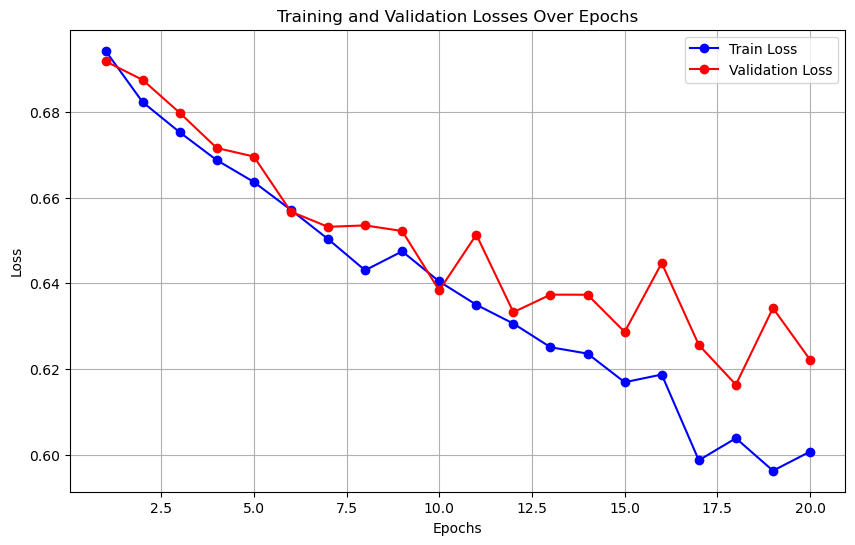

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for images, isic_ids in tqdm(test_loader, desc="Inference on Test"):
        images = images.to(device)
        logits = model(images).view(-1)  # shape [batch_size]
        probs = torch.sigmoid(logits)    # shape [batch_size], in [0,1]
        
        probs = probs.cpu().numpy()
        
        for isic_id, p in zip(isic_ids, probs):
            predictions.append({"isic_id": isic_id, "target": float(p)})

submission_df = pd.DataFrame(predictions)
submission_df = submission_df.sort_values(by="isic_id").reset_index(drop=True)

submission_file = "submission_I_RN50_2.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Saved submission with {len(submission_df)} rows to {submission_file}")
display(submission_df.head(10))

Inference on Test:   0%|          | 0/4 [00:00<?, ?it/s]

Saved submission with 100 rows to submission_I_RN50_2.csv


,isic_id,target
0,ISIC_0082829,0.564406
1,ISIC_0114227,0.375898
2,ISIC_0157465,0.537676
3,ISIC_0197356,0.264451
4,ISIC_0275647,0.408815
5,ISIC_0332355,0.276267
6,ISIC_0528190,0.533461
7,ISIC_0576478,0.349786
8,ISIC_0719839,0.486631
9,ISIC_0968965,0.542402


### 3. Unfrozen last layer - 0.36

In [ ]:
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
model.fc = nn.Linear(in_features=2048, out_features=1)

# Unfreeze last few layers (e.g., layer4 and fc)
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

EPOCHS = 20

# Initialize variables to track the best model
best_val_loss = float('inf')  # Start with a very large number
train_losses = []  # To store training losses
val_losses = []    # To store validation losses
best_model = None  # Variable to store the best model

for epoch in range(1, EPOCHS+1):

    # -- TRAINING --
    model.train()
    running_loss = 0.0
    
    for images, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images).view(-1)  # [batch_size]
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    
    # -- VALIDATING --

    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels, _ in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images).view(-1)
            loss = criterion(logits, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -- Check if this is the best model so far --
    if avg_val_loss < best_val_loss:
        #print(f"Validation loss decreased ({best_val_loss:.4f} -> {avg_val_loss:.4f}). Saving model...")
        best_val_loss = avg_val_loss
        best_model = model.state_dict()  # Save the model's state dict in the variable

# If you want to load the best model from the variable:
model.load_state_dict(best_model)
model = model.to(device)
print(f"Best model val loss: {best_val_loss}")

Epoch 1:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.6602 | Val Loss: 0.6331


Epoch 2:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.5782 | Val Loss: 0.5215


Epoch 3:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.4563 | Val Loss: 0.4869


Epoch 4:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.3930 | Val Loss: 0.4340


Epoch 5:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.3209 | Val Loss: 0.4251


Epoch 6:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.3391 | Val Loss: 0.4111


Epoch 7:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.2730 | Val Loss: 0.3639


Epoch 8:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.2485 | Val Loss: 0.4994


Epoch 9:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.2572 | Val Loss: 0.4178


Epoch 10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2204 | Val Loss: 0.3833


Epoch 11:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2383 | Val Loss: 0.4961


Epoch 12:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2237 | Val Loss: 0.4898


Epoch 13:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.1766 | Val Loss: 0.4771


Epoch 14:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.1521 | Val Loss: 0.5197


Epoch 15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.1668 | Val Loss: 0.5447


Epoch 16:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.1146 | Val Loss: 0.4694


Epoch 17:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0970 | Val Loss: 0.4147


Epoch 18:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.1105 | Val Loss: 0.4975


Epoch 19:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0938 | Val Loss: 0.5075


Epoch 20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0705 | Val Loss: 0.5921
Best model val loss: 0.3638677507638931


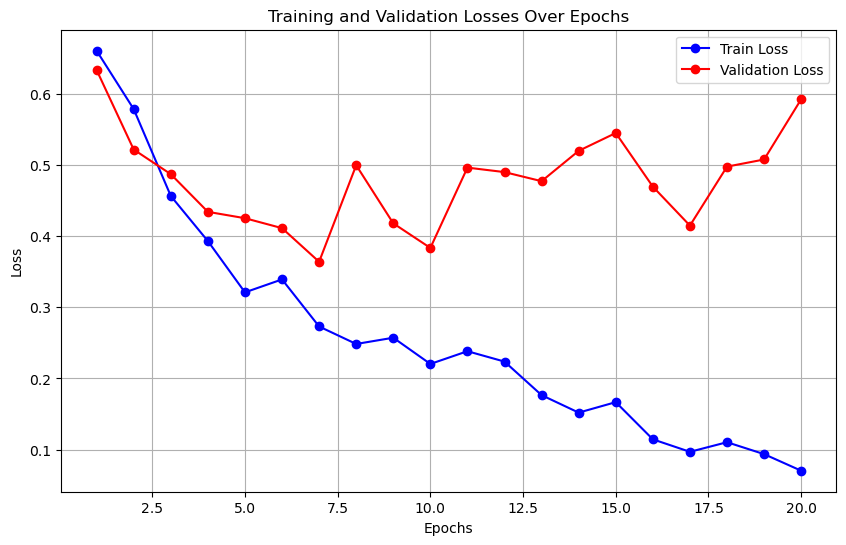

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for images, isic_ids in tqdm(test_loader, desc="Inference on Test"):
        images = images.to(device)
        logits = model(images).view(-1)  # shape [batch_size]
        probs = torch.sigmoid(logits)    # shape [batch_size], in [0,1]
        
        probs = probs.cpu().numpy()
        
        for isic_id, p in zip(isic_ids, probs):
            predictions.append({"isic_id": isic_id, "target": float(p)})

submission_df = pd.DataFrame(predictions)
submission_df = submission_df.sort_values(by="isic_id").reset_index(drop=True)

submission_file = "submission_I_RN50_3.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Saved submission with {len(submission_df)} rows to {submission_file}")
display(submission_df.head(10))

Inference on Test:   0%|          | 0/4 [00:00<?, ?it/s]

Saved submission with 100 rows to submission_I_RN50_3.csv


,isic_id,target
0,ISIC_0082829,0.982227
1,ISIC_0114227,0.019251
2,ISIC_0157465,0.016352
3,ISIC_0197356,0.056832
4,ISIC_0275647,0.164382
5,ISIC_0332355,0.019712
6,ISIC_0528190,0.997646
7,ISIC_0576478,0.001200
8,ISIC_0719839,0.999435
9,ISIC_0968965,0.776945


## EfficientNet

In [ ]:
model = models.efficientnet_b7(weights="EfficientNet_B7_Weights.DEFAULT")

# Replace final layer for binary classification
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 20

# Initialize variables to track the best model
best_val_loss = float('inf')  # Start with a very large number
train_losses = []  # To store training losses
val_losses = []    # To store validation losses
best_model = None  # Variable to store the best model

for epoch in range(1, EPOCHS+1):

    # -- TRAINING --
    model.train()
    running_loss = 0.0
    
    for images, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images).view(-1)  # [batch_size]
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    
    # -- VALIDATING --

    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels, _ in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images).view(-1)
            loss = criterion(logits, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -- Check if this is the best model so far --
    if avg_val_loss < best_val_loss:
        #print(f"Validation loss decreased ({best_val_loss:.4f} -> {avg_val_loss:.4f}). Saving model...")
        best_val_loss = avg_val_loss
        best_model = model.state_dict()  # Save the model's state dict in the variable

# If you want to load the best model from the variable:
model.load_state_dict(best_model)
model = model.to(device)
print(f"Best model val loss: {best_val_loss}")

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /Users/jorgecamposmarti/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:15<00:00, 17.0MB/s] 


Epoch 1:   0%|          | 0/18 [00:00<?, ?it/s]

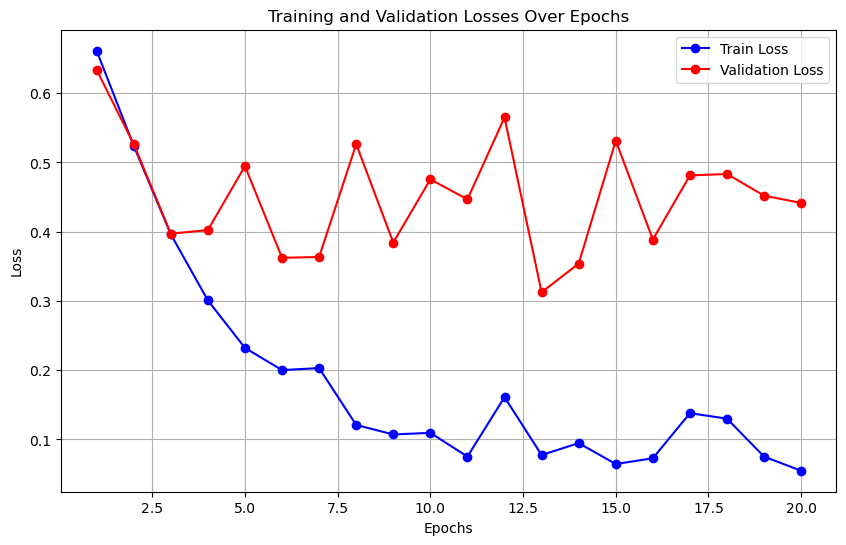

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for images, isic_ids in tqdm(test_loader, desc="Inference on Test"):
        images = images.to(device)
        logits = model(images).view(-1)  # shape [batch_size]
        probs = torch.sigmoid(logits)    # shape [batch_size], in [0,1]
        
        probs = probs.cpu().numpy()
        
        for isic_id, p in zip(isic_ids, probs):
            predictions.append({"isic_id": isic_id, "target": float(p)})

submission_df = pd.DataFrame(predictions)
submission_df = submission_df.sort_values(by="isic_id").reset_index(drop=True)

submission_file = "submission_I_ENB7_1.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Saved submission with {len(submission_df)} rows to {submission_file}")
display(submission_df.head(10))

Inference on Test:   0%|          | 0/4 [00:00<?, ?it/s]

Saved submission with 100 rows to submission_I_RN50_1.csv


,isic_id,target
0,ISIC_0082829,0.998039
1,ISIC_0114227,0.152868
2,ISIC_0157465,0.033230
3,ISIC_0197356,0.545594
4,ISIC_0275647,0.070164
5,ISIC_0332355,0.804810
6,ISIC_0528190,0.958261
7,ISIC_0576478,0.006062
8,ISIC_0719839,0.985423
9,ISIC_0968965,0.537542


## DenseNet

In [ ]:
model = models.densenet121(weights="DenseNet121_Weights.DEFAULT")

# Replace final layer for binary classification
model.classifier = nn.Linear(model.classifier.in_features, 1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 20

# Initialize variables to track the best model
best_val_loss = float('inf')  # Start with a very large number
train_losses = []  # To store training losses
val_losses = []    # To store validation losses
best_model = None  # Variable to store the best model

for epoch in range(1, EPOCHS+1):

    # -- TRAINING --
    model.train()
    running_loss = 0.0
    
    for images, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images).view(-1)  # [batch_size]
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    
    # -- VALIDATING --

    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels, _ in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images).view(-1)
            loss = criterion(logits, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -- Check if this is the best model so far --
    if avg_val_loss < best_val_loss:
        #print(f"Validation loss decreased ({best_val_loss:.4f} -> {avg_val_loss:.4f}). Saving model...")
        best_val_loss = avg_val_loss
        best_model = model.state_dict()  # Save the model's state dict in the variable

# If you want to load the best model from the variable:
model.load_state_dict(best_model)
model = model.to(device)
print(f"Best model val loss: {best_val_loss}")

Epoch 1:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.6613 | Val Loss: 0.6337


Epoch 2:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.5241 | Val Loss: 0.5265


Epoch 3:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.3963 | Val Loss: 0.3971


Epoch 4:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.3007 | Val Loss: 0.4023


Epoch 5:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.2321 | Val Loss: 0.4947


Epoch 6:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.2001 | Val Loss: 0.3623


Epoch 7:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.2030 | Val Loss: 0.3634


Epoch 8:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.1208 | Val Loss: 0.5263


Epoch 9:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.1071 | Val Loss: 0.3843


Epoch 10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.1094 | Val Loss: 0.4756


Epoch 11:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0752 | Val Loss: 0.4467


Epoch 12:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.1610 | Val Loss: 0.5650


Epoch 13:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0774 | Val Loss: 0.3125


Epoch 14:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0946 | Val Loss: 0.3538


Epoch 15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0644 | Val Loss: 0.5314


Epoch 16:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0727 | Val Loss: 0.3886


Epoch 17:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.1379 | Val Loss: 0.4813


Epoch 18:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.1300 | Val Loss: 0.4833


Epoch 19:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0750 | Val Loss: 0.4520


Epoch 20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0548 | Val Loss: 0.4414
Best model val loss: 0.3124964743852615


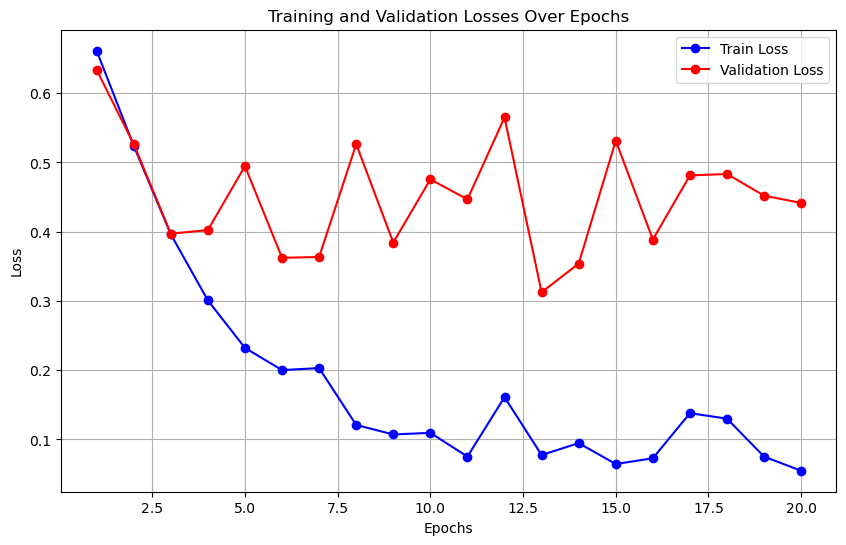

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for images, isic_ids in tqdm(test_loader, desc="Inference on Test"):
        images = images.to(device)
        logits = model(images).view(-1)  # shape [batch_size]
        probs = torch.sigmoid(logits)    # shape [batch_size], in [0,1]
        
        probs = probs.cpu().numpy()
        
        for isic_id, p in zip(isic_ids, probs):
            predictions.append({"isic_id": isic_id, "target": float(p)})

submission_df = pd.DataFrame(predictions)
submission_df = submission_df.sort_values(by="isic_id").reset_index(drop=True)

submission_file = "submission_I_DN121_1.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Saved submission with {len(submission_df)} rows to {submission_file}")
display(submission_df.head(10))

Inference on Test:   0%|          | 0/4 [00:00<?, ?it/s]

Saved submission with 100 rows to submission_I_RN50_1.csv


,isic_id,target
0,ISIC_0082829,0.998039
1,ISIC_0114227,0.152868
2,ISIC_0157465,0.033230
3,ISIC_0197356,0.545594
4,ISIC_0275647,0.070164
5,ISIC_0332355,0.804810
6,ISIC_0528190,0.958261
7,ISIC_0576478,0.006062
8,ISIC_0719839,0.985423
9,ISIC_0968965,0.537542


## VGG16

In [31]:
model = models.vgg16(weights='VGG16_Weights.DEFAULT')

# Replace final layer for binary classification
model.classifier[6] = nn.Linear(in_features=4096, out_features=1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 15

# Initialize variables to track the best model
best_auc = 0
train_losses = []  # To store training losses
val_losses = []    # To store validation losses
best_model = None  # Variable to store the best model

for epoch in range(1, EPOCHS+1):

    # -- TRAINING --
    model.train()
    running_loss = 0.0
    
    for images, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images).view(-1)  # [batch_size]
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    
    # -- VALIDATING --

    model.eval()
    val_loss = 0.0
    all_logits = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images).view(-1)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            all_logits.append(logits.cpu())  # Save logits
            all_labels.append(labels.cpu())  # Save true labels

    
    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    # Concatenate all predictions and labels
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    # Convert logits to probabilities using sigmoid
    probs = torch.sigmoid(all_logits)

    # Compute AUC-ROC
    auc = roc_auc_score(all_labels.numpy(), probs.numpy())
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val AUC: {auc:.4f}")

    # -- Check if this is the best model so far --
    if auc > best_auc:
        print('best until now')
        best_auc = auc
        best_model = model.state_dict()  # Save the model's state dict in the variable

# If you want to load the best model from the variable:
model.load_state_dict(best_model)
model = model.to(device)
print(f"Best model val ROC AUC: {best_auc}")

Epoch 1:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.7083 | Val Loss: 0.6713 | Val AUC: 0.6721
best until now


Epoch 2:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.6029 | Val Loss: 0.4836 | Val AUC: 0.8422
best until now


Epoch 3:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.6628 | Val Loss: 0.6233 | Val AUC: 0.8314


Epoch 4:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/15 | Train Loss: 0.4971 | Val Loss: 0.6182 | Val AUC: 0.8618
best until now


Epoch 5:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/15 | Train Loss: 0.4887 | Val Loss: 0.4376 | Val AUC: 0.8840
best until now


Epoch 6:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/15 | Train Loss: 0.4572 | Val Loss: 0.3975 | Val AUC: 0.8840


Epoch 7:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/15 | Train Loss: 0.5001 | Val Loss: 0.4469 | Val AUC: 0.8559


Epoch 8:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/15 | Train Loss: 0.4102 | Val Loss: 0.4222 | Val AUC: 0.8750


Epoch 9:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/15 | Train Loss: 0.3807 | Val Loss: 0.4166 | Val AUC: 0.8755


Epoch 10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/15 | Train Loss: 0.3709 | Val Loss: 0.5137 | Val AUC: 0.9027
best until now


Epoch 11:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/15 | Train Loss: 0.3732 | Val Loss: 0.4923 | Val AUC: 0.8810


Epoch 12:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/15 | Train Loss: 0.3102 | Val Loss: 0.4708 | Val AUC: 0.8893


Epoch 13:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/15 | Train Loss: 0.2747 | Val Loss: 0.4366 | Val AUC: 0.8972


Epoch 14:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/15 | Train Loss: 0.3125 | Val Loss: 0.3549 | Val AUC: 0.9199
best until now


Epoch 15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/15 | Train Loss: 0.2529 | Val Loss: 0.5442 | Val AUC: 0.8910
Best model val ROC AUC: 0.9199489035554608


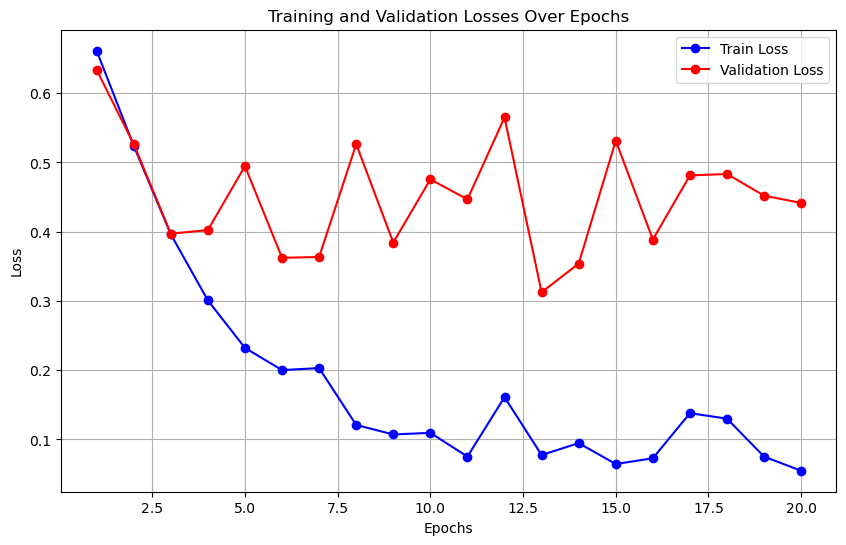

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
model.eval()
predictions = []

with torch.no_grad():
    for images, isic_ids in tqdm(test_loader, desc="Inference on Test"):
        images = images.to(device)
        logits = model(images).view(-1)  # shape [batch_size]
        probs = torch.sigmoid(logits)    # shape [batch_size], in [0,1]
        
        probs = probs.cpu().numpy()
        
        for isic_id, p in zip(isic_ids, probs):
            predictions.append({"isic_id": isic_id, "target": float(p)})

submission_df = pd.DataFrame(predictions)
submission_df = submission_df.sort_values(by="isic_id").reset_index(drop=True)

submission_file = "submission_I_VGG16_2.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Saved submission with {len(submission_df)} rows to {submission_file}")
display(submission_df.head(10))

Inference on Test:   0%|          | 0/4 [00:00<?, ?it/s]

Saved submission with 100 rows to submission_I_VGG16_2.csv


,isic_id,target
0,ISIC_0082829,0.921942
1,ISIC_0114227,0.592358
2,ISIC_0157465,0.023342
3,ISIC_0197356,0.282645
4,ISIC_0275647,0.007523
5,ISIC_0332355,0.641593
6,ISIC_0528190,0.988225
7,ISIC_0576478,0.031253
8,ISIC_0719839,0.770008
9,ISIC_0968965,0.836909
